# Toy example of score operator matching
In this example, we are trying to implement the score operator matching proposed in ''Score-based Generative Models in Function Space''(SGMFS) and acting as the simplest experiment to testify the feasibility of directly learning the score operator in infinite-dimensional stochastic shape processes. Specifically, we use the ''two moons'' in SciPy dataset as the target shape, this shape can be discretized into arbitrary numbers of points, but essentially, the ''two moons shape'' acts as a fixed target function, while the initial shape can be sampled from a pure Gaussian field, and we hope to bridge these two, i.e., the process should start from a random Gaussian shape (represented by randomly-distributed points) and end with the two moons. We expect through only training network (neural operator) once for a low resolution discretization, it can generalize to other discretization resolutions, that is, it learns the operator.

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/vbd402/Documents/Projects/scoreoperator


/opt/homebrew/Caskroom/miniconda/base/envs/jax/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import wandb
from flax.training import train_state, checkpoints
from tqdm import tqdm


from src.data.toys.toy_shapes import TwoMoons, Circle
from src.models.nerualop.FNO import TimeDependentFNO1D
from src.models.diffusion.gaussian_process import GaussianRandomField

### Circle shape

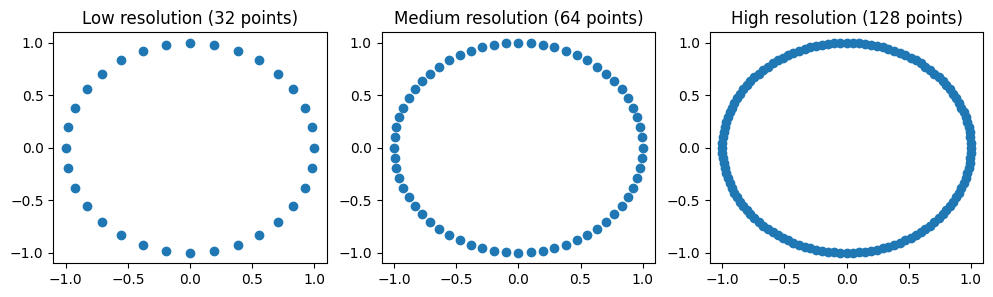

In [3]:
unit_circle = Circle()

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(unit_circle.sample(32)[:, 0], unit_circle.sample(32)[:, 1])
ax[0].set_title('Low resolution (32 points)')
ax[1].scatter(unit_circle.sample(64)[:, 0], unit_circle.sample(64)[:, 1])
ax[1].set_title('Medium resolution (64 points)')
ax[2].scatter(unit_circle.sample(128)[:, 0], unit_circle.sample(128)[:, 1])
ax[2].set_title('High resolution (128 points)')
plt.show()

### Noising using Gaussian random fields
In SGMFS paper, the authors suggest using a Hilbert-valued Gaussian process to perturb the data, the generalization of Gaussian processes is the Gaussian random field (GRF). Informally, a GRF is an element in the Hilbert space, where contains the functions that maps from $\mathbb{R}^m$ to $\mathbb{R}^n$, when $m=1$, it is usually referred as Gaussian process. The simplest GRF is the white noise field, that is, with the identity covariance operator, it looks actually like every common "blob-like" noise we see. However, in the paper, they suggest using a more structured GRF rather than white noise, since the unstructured noise is hard to converge for the training on high-resolution. Here, I implemented three different types of GRF, characterized by different kernels, they are white noise, Matérn-type (haven't quite understood yet) and radius basis function (RBF).

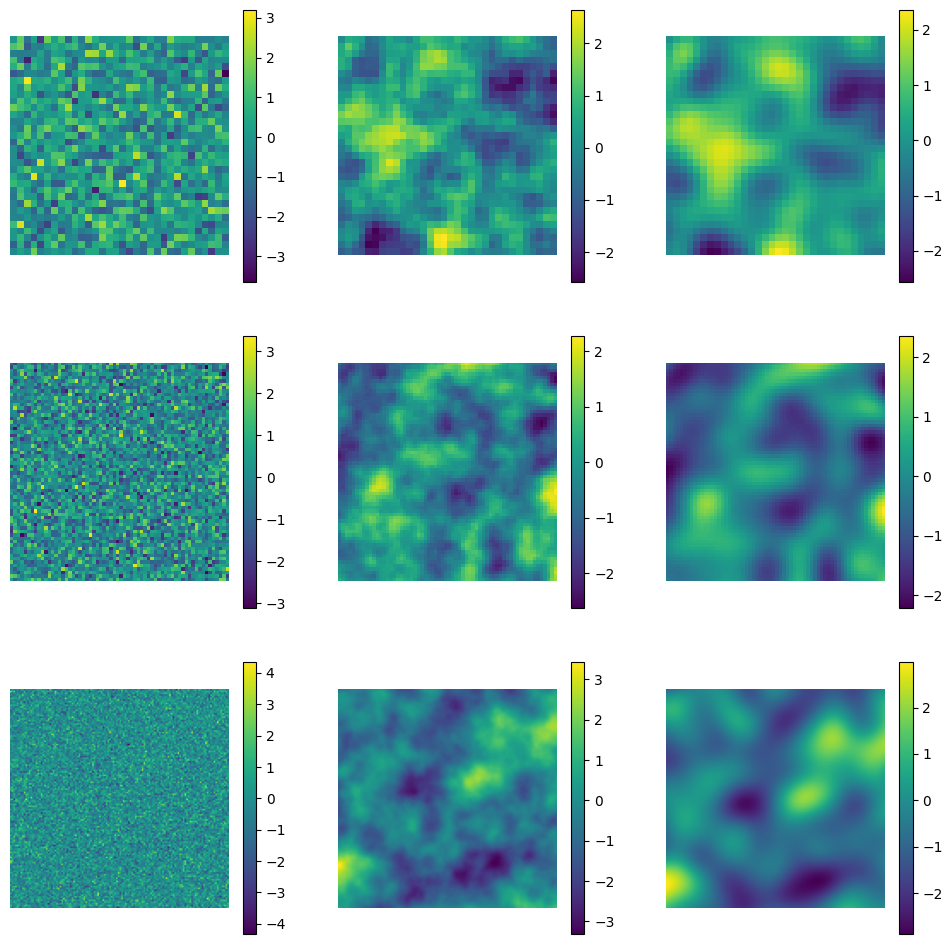

In [5]:
key = jax.random.PRNGKey(42)

white_noise_low = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=32, kernel_type='delta', sigma=1.0)
white_noise_medium = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=64, kernel_type='delta', sigma=1.0)
white_noise_high = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=128, kernel_type='delta', sigma=1.0)

matern_grf_low = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=32, kernel_type='matern', sigma=1.0, kappa=0.1, nu=1.5)
matern_grf_medium = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=64, kernel_type='matern', sigma=1.0, kappa=0.1, nu=1.5)
matern_grf_high = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=128, kernel_type='matern', sigma=1.0, kappa=0.1, nu=1.5)

rbf_grf_low = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=32, kernel_type='gaussian', sigma=1.0, kappa=0.1)
rbf_grf_medium = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=64, kernel_type='gaussian', sigma=1.0, kappa=0.1)
rbf_grf_high = GaussianRandomField(input_dim=2, output_dim=1, n_sample_pts=128, kernel_type='gaussian', sigma=1.0, kappa=0.1)

_white_noise_low = white_noise_low.sample(key)
_white_noise_medium = white_noise_medium.sample(key)
_white_noise_high = white_noise_high.sample(key)

_matern_grf_low = matern_grf_low.sample(key)
_matern_grf_medium = matern_grf_medium.sample(key)
_matern_grf_high = matern_grf_high.sample(key)

_rbf_grf_low = rbf_grf_low.sample(key)
_rbf_grf_medium = rbf_grf_medium.sample(key)
_rbf_grf_high = rbf_grf_high.sample(key)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
im1 = ax[0, 0].imshow(_white_noise_low)
fig.colorbar(im1, ax=ax[0, 0])
im2 = ax[1, 0].imshow(_white_noise_medium)
fig.colorbar(im2, ax=ax[1, 0])
im3 = ax[2, 0].imshow(_white_noise_high)
fig.colorbar(im3, ax=ax[2, 0])

im4 = ax[0, 1].imshow(_matern_grf_low)
fig.colorbar(im4, ax=ax[0, 1])
im5 = ax[1, 1].imshow(_matern_grf_medium)
fig.colorbar(im5, ax=ax[1, 1])
im6 = ax[2, 1].imshow(_matern_grf_high)
fig.colorbar(im6, ax=ax[2, 1])

im7 = ax[0, 2].imshow(_rbf_grf_low)
fig.colorbar(im7, ax=ax[0, 2])
im8 = ax[1, 2].imshow(_rbf_grf_medium)
fig.colorbar(im8, ax=ax[1, 2])
im9 = ax[2, 2].imshow(_rbf_grf_high)
fig.colorbar(im9, ax=ax[2, 2])

# set all axes to be invisible
for i in range(3):
    for j in range(3):
        ax[i, j].axis('off')

We shall use the white noise and RBF GRF as examples. However, the choices are not restricted, for example, the Kunita process we used for modelling the shapes is another type of GRF and may be integrated into the framework, but we need to explore more.

### Perturb shape with GRF
Like normal diffusion generative models, we need to perturb the data with multiple-level scale noise fields, which is controlled by the parameter `sigma` in the implementation. In "Score-based Generative Model through Stochastic Differential Equations" paper, the author propose to perturb the data in a continuous way, that is, using a stochastic differential equation (SDE). Here, we use the Variance-Preserving (VP) SDE in the paper since it leads to the final distribution with zero mean and it is easy to sample from:
$$ 
d\mathbf{x} = -\frac{1}{2}\beta(t)\mathbf{x} dt + \sqrt{\beta(t)} d\mathbf{\eta} 
$$
where $\mathbf{x}$ is the function and $\mathbf{\eta}$ is the Gaussian process as shown above. We need to choose appropriate $\beta(t)$ to control the amplitude of the noise. For simplicity, we choose linear $\beta(t)$ as:
$$ 
\beta(t) = \beta_{\min} + t \cdot (\beta_{\max} - \beta_{\min}) 
$$
Moreover, SGMSDE paper derives the transition kernel for the VPSDE between arbitrarily long step as:
$$
p(\mathbf{x}(t)\mid \mathbf{x}(0)) = \mathcal{N}\left(\mathbf{x}; \mathbf{x}(0)\cdot\exp\left(-\frac{1}{2}\int^t_0\beta(s)ds\right), \mathbf{I}-\mathbf{I}\cdot\exp\left(-\int^t_0\beta(s)ds\right)\right)
$$
Plug $\beta(t)$ into the expression and we get the actual form of perturbation kernel as:
$$
p(\mathbf{x}(t)\mid \mathbf{x}(0)) = \mathcal{N}\left(\mathbf{x}; \mathbf{x}(0)\cdot\exp\left(-\frac{1}{4}t^2(\beta_{\max}-\beta_{\min})-\frac{1}{2}t\beta_{\min}\right), \mathbf{I}-\mathbf{I}\cdot\exp\left(-\frac{1}{2}t^2(\beta_{\max}-\beta_{\min})-t\beta_{\min}\right)\right)
$$
(NB: In the latter application for the nonlinear shape process, we have no access to this transition density, mostly because it is not Gaussian anymore, instead we can only know the small step Gaussian approximation under Euler-Maruyama scheme and we need to simulate the whole process to the point we want to evaluate. Here the closed form of transition density enable us to directly sample from the path at arbitrary steps without actually simulating it from the beginning, which saves lots of time for a demonstration)

Unlike the common way in normal generative models:
$$ 
\mathbf{x}(t) = \mathbf{x}(0)\cdot\mathbf{\mu}(t) + \Sigma^{1/2}(t)\cdot\mathbf{z},\quad \mathbf{z}\sim\mathcal{N}(0, \mathbf{I})
$$
we want to perturb the function data by GP, that is
$$ 
\mathbf{x}(t) = \mathbf{x}(0)\cdot\mathbf{\mu}(t) + \Sigma^{1/2}(t)\cdot\mathbf{z},\quad \mathbf{z}\sim\operatorname{GP}(0, k)
$$


In [4]:
class VPSDE:
    def __init__(self, beta_min, beta_max, gp):
        self._beta_min = beta_min
        self._beta_max = beta_max
        self._gp = gp

    def beta(self, t):
        return self._beta_min + (self._beta_max - self._beta_min) * t
    
    def f(self, x, t):
        return -0.5 * self.beta(t) * x
    
    def g(self, x, t):
        return jnp.sqrt(self.beta(t))

    def transition_prob(self, x0, t):
        log_mean_coeff = -0.25 * t**2 * (self._beta_max - self._beta_min) - 0.5 * t * self._beta_min
        mean = jnp.exp(log_mean_coeff) * x0
        std = jnp.sqrt(1 - jnp.exp(2.0 * log_mean_coeff))
        return mean, std
    
    def sample(self, x0, t, key, verbose=False):
        mean, std = self.transition_prob(x0, t)
        z = self._gp.sample(key)
        xt = mean + std * z
        if verbose:
            return xt, t, z
        else:
            return xt
        
    
class DiffusionLoader:
    def __init__(self, sde, seed, init_cond, batch_size, shuffle=True):
        self._sde = sde
        self._key = jax.random.PRNGKey(seed)
        self._batch_size = batch_size
        self._init_cond = init_cond
        self._shuffle = shuffle
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self._update_key()
        ts = self._sample_t(self._key)
        keys = jax.random.split(self._key, num=self._batch_size)
        xts, ts, zs = jax.vmap(self._sde.sample, in_axes=(None, 0, 0, None))(self._init_cond, ts, keys, True)
        return xts, ts, zs

    def _update_key(self):
        self._key, _ = jax.random.split(self._key)
    
    def _sample_t(self, key):
        if self._shuffle:
            ts = jax.random.uniform(key, (self._batch_size, ))
        else:
            ts = jnp.linspace(0., 1., self._batch_size)
        return ts

#### Perturb by white noise fields

In [7]:
n_sample_pts = 16

gp_independent = GaussianRandomField(input_dim=1, output_dim=2, n_sample_pts=n_sample_pts, kernel_type='delta', sigma=1.0)
sde = VPSDE(1e-4, 0.1, gp_independent)

x0 = unit_circle.sample(n_sample_pts)
diffusion_loader = DiffusionLoader(sde, seed=42, init_cond=x0, batch_size=4, shuffle=False)

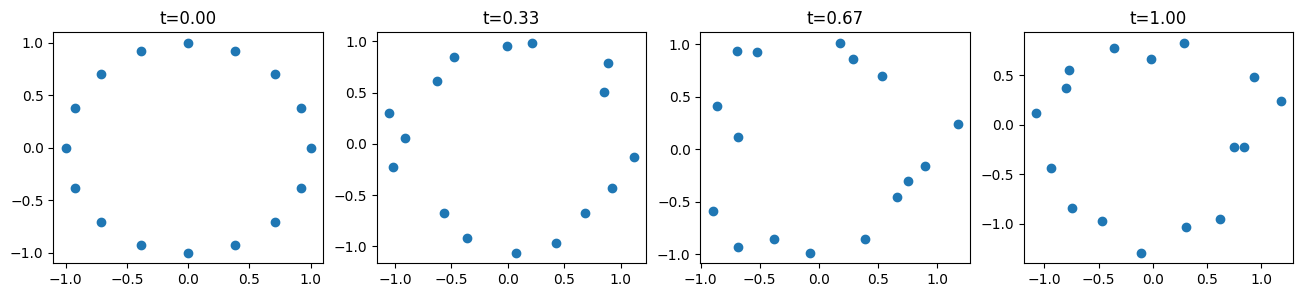

In [8]:
xs, ts, zs = next(diffusion_loader)
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for i in range(4):
    ax[i].scatter(xs[i, :, 0], xs[i, :, 1])
    ax[i].set_title(f't={ts[i]:.2f}')

### Perturb by RBF kernel GP

In [9]:
gp_RBF = GaussianRandomField(input_dim=1, output_dim=2, n_sample_pts=n_sample_pts, kernel_type='gaussian', sigma=1.0, kappa=0.05)
sde = VPSDE(1e-4, 0.1, gp_RBF)

x0 = unit_circle.sample(n_sample_pts)
diffusion_loader = DiffusionLoader(sde, seed=42, init_cond=x0, batch_size=4, shuffle=False)

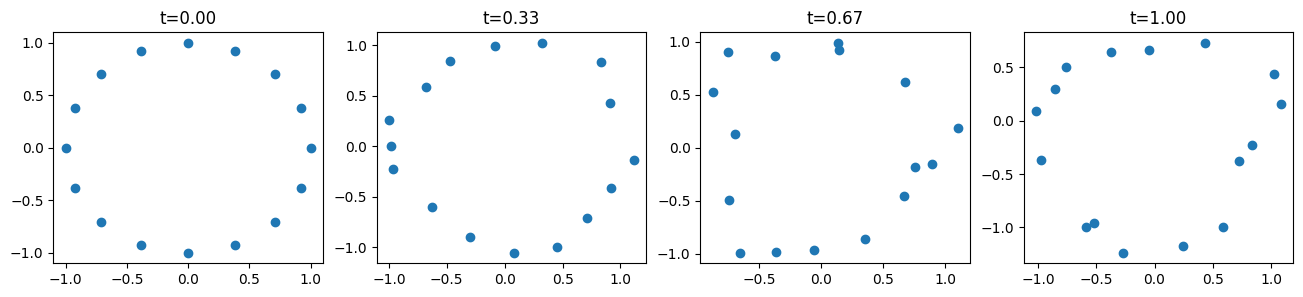

In [10]:
xs, ts, zs = next(diffusion_loader)
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for i in range(4):
    ax[i].scatter(xs[i, :, 0], xs[i, :, 1])
    ax[i].set_title(f't={ts[i]:.2f}')

### Denoising score operator matching
SDMFS proposed to use a inf-dim DSM loss function via neural operator to learn the score operator, the object is defined as:
$$
\underset{\theta}{\min}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\mathbb{E}_{\eta\sim \operatorname{GP}(0, k)}\left[\| \eta + F_{\theta}(\mathbf{x}+\eta) \|^2 \right]
$$

In [5]:
class TrainState(train_state.TrainState):
    batch_stats: dict


class TrainerModule:

    def __init__(self,
                 wandb_config,
                ):
        self._model_config = wandb_config.model_config
        self._optimizer_config = wandb_config.optimizer_config
        self._training_config = wandb_config.training_config
        self._record_config = wandb_config.record_config
        self._seed = wandb_config.seed
        self._init_cond = unit_circle.sample(wandb_config.gp_config.n_sample_pts)

        gp = GaussianRandomField(**wandb_config.gp_config)
        sde = VPSDE(**wandb_config.sde_config, gp=gp)
        self._model = TimeDependentFNO1D(**self._model_config)
        self._diffusion_train_loader = DiffusionLoader(sde, self._seed, self._init_cond, self._training_config.train_batch_size)
        self._diffusion_eval_loader = DiffusionLoader(sde, self._seed, self._init_cond, self._training_config.eval_batch_size)

        self.create_functions()
        self.init_model()

    def dsm_loss(self, preds, zs):
        loss = jnp.mean(
            jnp.mean(
                jnp.sum((preds + zs)**2, axis=-1),
                axis=-2
            ),
            axis=0
        )
        return loss

    
    def create_functions(self):
        
        def compute_loss(params, batch_stats, batch, train):
            xs, ts, zs = batch

            outs = self._model.apply(
                {"params": params, "batch_stats": batch_stats},
                xs,
                ts,
                train=train,
                mutable=["batch_stats"] if train else False
            )

            preds, new_model_state = outs if train else (outs, None)
            loss = self.dsm_loss(preds, zs)
            return loss, new_model_state
    
        def train_step(state, batch):
            loss_fn = lambda params: compute_loss(params, state.batch_stats, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, new_model_state = ret
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state["batch_stats"])
            return state, loss
        
        def eval_step(state, batch):
            xs, ts, zs = batch
            preds = state.apply_fn(
                {"params": state.params, "batch_stats": state.batch_stats},
                xs,
                ts,
                train=False,
                mutable=False
            )
            return self.dsm_loss(preds, zs)
        
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        xs, ts, _ = next(self._diffusion_eval_loader)
        init_rng_key = jax.random.PRNGKey(self._seed)
        variables = self._model.init(init_rng_key, xs, ts, train=True)
        self.init_params = variables["params"]
        self.init_batch_stats = variables["batch_stats"] if "batch_stats" in variables else {}
        self.state = None
    
    def init_optimizer(self):
        num_epochs = self._training_config.num_epochs
        num_steps_per_epoch = self._training_config.num_steps_per_epoch

        if self._optimizer_config.name.lower() == 'sgd':
            opt_class = optax.sgd
            lr_schedule = optax.piecewise_constant_schedule(
                init_value=self._optimizer_config.learning_rate,
                boundaries_and_scales={
                    int(num_epochs*num_steps_per_epoch*0.6): 0.1,
                    int(num_epochs*num_steps_per_epoch*0.85): 0.1
                }
            )
        elif self._optimizer_config.name.lower() == 'adam':
            opt_class = optax.adam
            lr_schedule = optax.warmup_cosine_decay_schedule(
                init_value=0.0,
                peak_value=self._optimizer_config.learning_rate,
                warmup_steps=self._optimizer_config.warmup_steps,
                decay_steps=int(num_epochs*num_steps_per_epoch*0.85),
                end_value=0.01*self._optimizer_config.learning_rate
            )
        else:
            raise NotImplementedError(f"{self._optimizer_config.name} has not implemented!")
        
        optimizer = optax.chain(
            optax.clip(1.0),
            opt_class(lr_schedule)
        )
        self.state = TrainState.create(
            apply_fn=self._model.apply,
            params=self.init_params if self.state is None else self.state.params,
            batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
            tx=optimizer
        )

    def train_epoch(self):
        train_losses = []
        for _ in tqdm(range(self._training_config.num_steps_per_epoch), desc="Epoch training", leave=False, unit="batch"):
            batch = next(self._diffusion_train_loader)
            self.state, loss = self.train_step(self.state, batch)
            train_losses.append(loss)
        avg_train_loss = np.stack(jax.device_get(train_losses)).mean()
        return avg_train_loss


    def train_model(self):
        self.init_optimizer()

        with tqdm(range(self._training_config.num_epochs), desc="Training", unit="epoch") as pbar:
            for epoch in pbar:
                epoch_avg_loss = self.train_epoch()
                # pbar.set_postfix(Epoch=epoch, loss=f"{epoch_avg_loss:.4f}")
            
                eval_batch = next(self._diffusion_eval_loader)
                eval_loss = self.eval_step(self.state, eval_batch)
                
                # wandb.log({
                #     "train_avg_loss": epoch_avg_loss,
                #     "eval_loss": eval_loss
                # }, step=epoch)
                pbar.set_postfix(Epoch=epoch, train_loss=f"{epoch_avg_loss:.4f}", eval_loss=f"{eval_loss:.4f}")

    def save_model(self, save_dir, step=0):
        ckpt_dir = save_dir if save_dir else self._record_config.save_dir
        checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,
                                    target={
                                        "params": self.state.params,
                                        "batch_stats": self.state.batch_stats
                                    },
                                    step=step,
                                    overwrite=True)
    
    def load_model(self, load_dir, pretrained=False):
        load_dir = load_dir if load_dir else self._record_config.save_dir
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self._record_config.save_dir, target=None)
        else:
            assert self.checkpoint_exists(load_dir), "There is no pretrained model available!"
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(load_dir, f"{self.model_name}.ckpt"), target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict["params"],
                                       batch_stats=state_dict["batch_stats"],
                                       tx=self.state.tx if self.state else optax.sgd(0.1))
    
    def checkpoint_exists(self, load_dir):
        return os.path.isfile(os.path.join(load_dir, f"{self.model_name}.ckpt"))

In [6]:
from easydict import EasyDict as edict

config = edict({
    "gp_config": {"input_dim": 1,
                  "output_dim": 2,
                  "n_sample_pts": 16,
                  "kernel_type": "delta",
                  "sigma": 1.0,
                #   "kappa": 0.5,
    },
    "sde_config": {"beta_min": 1e-4,
                   "beta_max": 0.1
    },
    "model_config": {"output_dim": 2,
                     "lifting_dims": [8, 8, 8],
                     "max_n_modes": [8, 8, 8],
                     "activation": "relu",
                     "time_encoding_dim": 64,
                     "time_incrop_method": "time_modulated",
    },
    "optimizer_config": {"name": "adam",
                         "learning_rate": 1e-3,
                         "warmup_steps": 200,
    },
    "training_config": {"train_batch_size": 64,
                        "eval_batch_size": 32,
                        "num_steps_per_epoch": 200,
                        "num_epochs": 100,
    },
    "record_config": {"save_dir": "../pretrained/",
                      "load_dir": "../pretrained/"
    },
    "seed": 1234,
})
# wandb.init(project="score_operator", name="circle_demo", config=config)

In [7]:
# wandb_config = wandb.config
trainer = TrainerModule(config)

In [8]:
trainer.train_model()

Training: 100%|██████████| 100/100 [01:05<00:00,  1.53epoch/s, Epoch=99, eval_loss=0.0556, train_loss=0.0852]


In [9]:
def infer_score(train_state, x, t):
    score_out = train_state.apply_fn(
        {"params": trainer.state.params, "batch_stats": trainer.state.batch_stats},
        x,
        t,
        train=False,
        mutable=False
    )
    return score_out.squeeze()

In [67]:
circle = Circle(radius=1.3)
x1 = circle.sample(16)
x2 = circle.sample(32)
x3 = circle.sample(64)
t = jnp.array([0.5])
score1 = infer_score(trainer.state, jnp.expand_dims(x1, axis=0), t)
score2 = infer_score(trainer.state, jnp.expand_dims(x2, axis=0), t)
score3 = infer_score(trainer.state, jnp.expand_dims(x3, axis=0), t)
print(f"{score1.shape=}, {score2.shape=}, {score3.shape=}")

score1.shape=(16, 2), score2.shape=(32, 2), score3.shape=(64, 2)


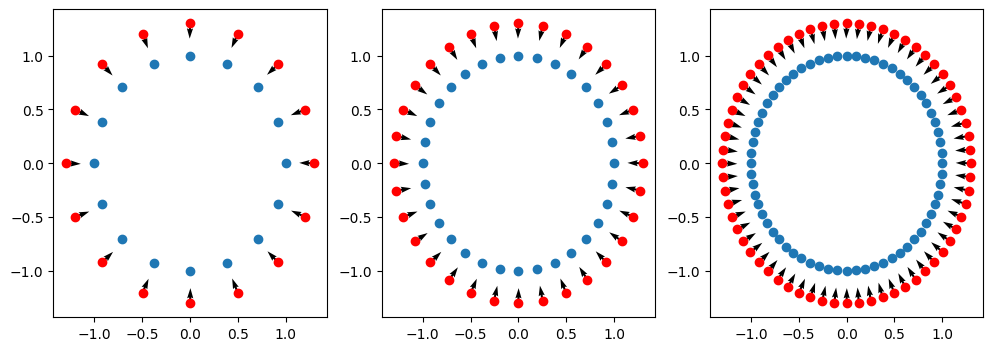

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].quiver(x1[:, 0], x1[:, 1], score1[:, 0], score1[:, 1])
ax[0].scatter(unit_circle.sample(16)[:, 0], unit_circle.sample(16)[:, 1])
ax[0].scatter(x1[:, 0], x1[:, 1], color='r')
ax[1].quiver(x2[:, 0], x2[:, 1], score2[:, 0], score2[:, 1])
ax[1].scatter(unit_circle.sample(32)[:, 0], unit_circle.sample(32)[:, 1])
ax[1].scatter(x2[:, 0], x2[:, 1], color='r')
ax[2].quiver(x3[:, 0], x3[:, 1], score3[:, 0], score3[:, 1])
ax[2].scatter(unit_circle.sample(64)[:, 0], unit_circle.sample(64)[:, 1])
ax[2].scatter(x3[:, 0], x3[:, 1], color='r')

In [69]:
class ReverseVPSDE(VPSDE):
    def __init__(self, beta_min, beta_max, gp, score_fn):
        super().__init__(beta_min, beta_max, gp)
        self._score_fn = score_fn

    def f(self, x, t):
        return -0.5 * self.beta(t) * x + self.beta(t) * self._score_fn(x, t)
    
    def g(self, x, t):
        return jnp.sqrt(self.beta(t)) * jnp.eye(x.shape[0])

In [94]:
def score_fn(x, t):
    x = x.reshape(-1, 2)
    x = jnp.expand_dims(x, axis=0)
    t = jnp.expand_dims(t, axis=0)
    score = infer_score(trainer.state, x, t)
    return score.squeeze().flatten()

n_sample_pts = 32
circle = Circle(radius=2.0)
x0 = circle.sample(n_sample_pts).flatten()
gp_independent = GaussianRandomField(input_dim=1, output_dim=2, n_sample_pts=n_sample_pts, kernel_type='delta', sigma=1.0)
reverse_sde = ReverseVPSDE(1e-4, 0.1, gp_independent, score_fn)

In [95]:
import diffrax as drx

In [96]:
drift = lambda t, y, args: reverse_sde.f(y, t)
diffusion = lambda t, y, args: reverse_sde.g(y, t)
brownian_motion = drx.VirtualBrownianTree(t0=0.0, t1=1.0, tol=1e-3, shape=((2*n_sample_pts,)), key=jax.random.PRNGKey(4))
terms = drx.MultiTerm(drx.ODETerm(drift), drx.ControlTerm(diffusion, brownian_motion))
solver = drx.Euler()
saveat = drx.SaveAt(ts=jnp.linspace(0.0, 1.0, 100))
sol = drx.diffeqsolve(terms, solver, 0.0, 1.0, 1e-2, x0, saveat=saveat)

In [99]:
xs = sol.ys.reshape(-1, n_sample_pts, 2)

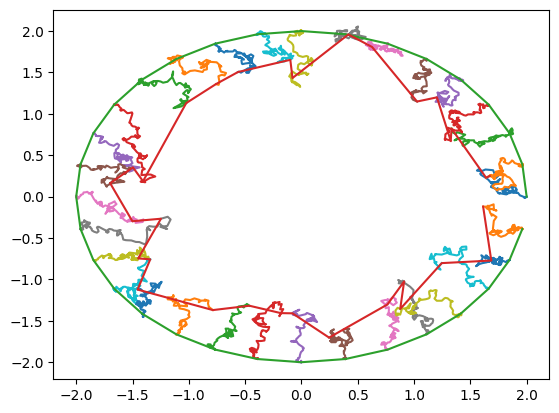

In [100]:
for pt_idx in range(n_sample_pts):
    plt.plot(xs[:, pt_idx, 0], xs[:, pt_idx, 1])
plt.plot(xs[0, :, 0], xs[0, :, 1])
plt.plot(xs[-1, :, 0], xs[-1, :, 1])